In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from keras.utils import to_categorical

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

Using Theano backend.


Load the dataset by splitting it into (X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig). We have used ‘orig’ because later we need to process the data for which we’ll then later assign the simpler (x_train, y_train), (x_test, y_test).

In [9]:
from keras.datasets import mnist

(X_train_orig, Y_train_orig), (X_test_orig, Y_test_orig) = mnist.load_data()


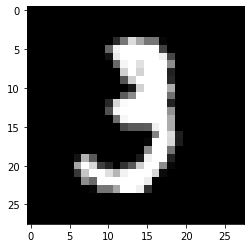

In [10]:
# Example of a picture
index = 10
plt.imshow(X_train_orig[index])


Processing the data for y labels. We first reshape the original y_train and y_test into (60000, 1) and (10000, 1) respectively, because by default the Tensorflow dataset has this weird shape of (60000,) and (10000,). Then we use ‘to_categorical’ function to One Hot Encode them to 10 classes by passing the argument ‘num_classes=10’. Then the data is transposed to give us y_train and y_test.

In [11]:
Y_tr_resh = Y_train_orig.reshape(60000, 1)
Y_te_resh =  Y_test_orig.reshape(10000, 1)
Y_tr_T = to_categorical(Y_tr_resh, num_classes=10)
Y_te_T = to_categorical(Y_te_resh, num_classes=10)
y_train = Y_tr_T.T
y_test = Y_te_T.T

Processing the data for x pixel intensity input values. Originally the x train and test set have this format for their shape which is (60000, 28, 28) and (10000, 28, 28) wherein each image is 28 by 28 pixels in size. To apply the concept of Deep Learning here, we need to ROLL out that 28 by 28 pixels square into a horizontal line containing the same pixels, i.e in total 28*28 = 784 pixels. This process is known as FLATTENING the image. Later we divide both the train and test set by 255. to normalize the pixel intensity values between 0 and 1 for further calculations to give us x_train and x_test.

In [13]:
#Some preprocessing step
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
x_train = X_train_flatten / 255.
x_test = X_test_flatten / 255.

Define the Activation Functions. Here we’ll use Relu for the hidden layer activations and Sigmoid for the output layer activations.

In [14]:
#Activation functions

def sigmoid(Z):

    S = 1 / (1 + np.exp(-Z))

    return S

def relu(p):
    return np.maximum(0, p)

def softmax(u):
    return np.exp(u) / np.sum(np.exp(u), axis=0, keepdims=True)

Initialise the Weights and Biases for each of the layers. We use a ‘for loop’ to do that and simplify our work and feed in the array with the total number of units in each layer (including the input layer). We initialize the weights randomly and initialize the biases to zeros.

In [15]:
parameters = {}
def initialize_parameters(layer_dims):
    L = len(layer_dims)
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * (np.sqrt(2 / layer_dims[l - 1]))
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

In [16]:
#Forward Propagation

outputs = {}
activation = {}
def forward_prop(parameters, x_train, activation):
    m = x_train.shape[1]
    outputs["Z" + str(1)] = np.dot(parameters["W1"], x_train) + parameters["b1"]
    activation["A" + str(1)] = relu(outputs["Z" + str(1)])
    for l in range(2, 4):
        outputs["Z" + str(l)] = np.dot(parameters["W" + str(l)], activation["A" + str(l - 1)]) + parameters["b" + str(l)]
        activation["A" + str(l)] = relu(outputs["Z" + str(l)])
    outputs["Z4"] = np.dot(parameters["W4"], activation["A3"]) + parameters["b4"]
    activation["A4"] = sigmoid(outputs["Z4"])
    return outputs, activation

In [17]:
#Compute the Cost using the cross entropy loss.

def compute_cost(activation):
    loss = - np.sum((y_train * np.log(activation["A4"])), axis=0, keepdims=True)
    cost = np.sum(loss, axis=1) / m
    return cost

In [18]:
#Define a function to calculate the derivative of the Relu activation function

def drelu(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

In [19]:
#Compute the gradients of the Loss w.r.t the Weights and the Biases

grad_reg = {}
m = x_train.shape[1]
def grad_re(parameters, outputs, activation):
    grad_reg["dZ4"] = (activation["A4"] - y_train) / m
    for l in range(1, 4):
        grad_reg["dA" + str(4 - l)] = np.dot(parameters["W" + str(4 - l + 1)].T, grad_reg["dZ" + str(4 - l + 1)])
        grad_reg["dZ" + str(4 - l)] = grad_reg["dA" + str(4 - l)] * drelu(outputs["Z" + str(4 - l)])
    grad_reg["dW1"] = np.dot(grad_reg["dZ1"], x_train.T)
    grad_reg["db1"] = np.sum(grad_reg["dZ1"], axis=1, keepdims=True)
    for l in range(2, 5):
        grad_reg["dW" + str(l)] = np.dot(grad_reg["dZ" + str(l)], activation["A" + str(l - 1)].T)
        grad_reg["db" + str(l)] = np.sum(grad_reg["dZ" + str(l)], axis=1, keepdims=True)
    return parameters, outputs, activation, grad_reg

Update the parameters using gradient descent algorithm in which you minimize the Cost function with the parameters.

In [20]:
def learning(grad_reg, learning_rate=0.005):
    for i in range(1, 5):
        parameters["W" + str(i)] = parameters["W" + str(i)] - (learning_rate * grad_reg["dW" + str(i)])
        parameters["b" + str(i)] = parameters["b" + str(i)] - (learning_rate * grad_reg["db" + str(i)])
    return parameters

Put together all these above functions into another function which is the model we’ll be executing for the final computations.

In [21]:
num_iterations = 1000
print_cost = True
costs = []
def grad_descent(num_iterations, costs, activation):
    initialize_parameters([x_train.shape[0], 50, 50, 50, 10])
    for l in range(0, num_iterations):
        forward_prop(parameters, x_train, activation)
        cost = compute_cost(activation)
        grad_re(parameters, outputs, activation)
        learning(grad_reg, learning_rate=0.005)
        if l % 100 == 0:
            costs.append(cost)
        if print_cost and l % 100 == 0:
            print("Cost after iteration %i: %f" % (l, cost))
    return costs, parameters

In [22]:
#Call the function ‘grad_descent’ to start the computations of jiggling the parameters.

grad_descent(num_iterations, costs, activation)

Cost after iteration 0: 0.675536
Cost after iteration 100: 2.102219
Cost after iteration 200: 1.859564
Cost after iteration 300: 1.611932
Cost after iteration 400: 1.369929
Cost after iteration 500: 1.171678
Cost after iteration 600: 1.018478
Cost after iteration 700: 0.902558
Cost after iteration 800: 0.819220
Cost after iteration 900: 0.757909


([array([0.67553647]),
  array([2.10221928]),
  array([1.8595642]),
  array([1.61193236]),
  array([1.36992932]),
  array([1.17167823]),
  array([1.01847817]),
  array([0.90255827]),
  array([0.81922012]),
  array([0.75790898])],
 {'W1': array([[ 0.08204183, -0.03089836, -0.0266767 , ..., -0.05589038,
          -0.01814356,  0.02552564],
         [ 0.06151531, -0.09801919, -0.04071815, ...,  0.01046669,
          -0.07242949,  0.03166355],
         [ 0.01514346, -0.09377455, -0.10864409, ..., -0.09870159,
           0.00940572, -0.00019344],
         ...,
         [-0.0267129 , -0.01666229,  0.00691156, ..., -0.00192238,
           0.02148839,  0.04283342],
         [-0.00016318, -0.04076022, -0.04117455, ..., -0.00455056,
           0.00381343, -0.04118358],
         [-0.01885479, -0.07444361,  0.07527455, ...,  0.03078283,
          -0.00090665,  0.04368365]]), 'b1': array([[-0.01268817],
         [ 0.12163693],
         [-0.02830633],
         [-0.01604588],
         [ 0.01505161],


In [24]:
def predict(parameters, x_test):
    forward_prop(parameters, x_test, activation)
    predictions = np.round(activation["A4"])
    return predictions
predictions = predict(parameters, x_test)

print(predictions)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


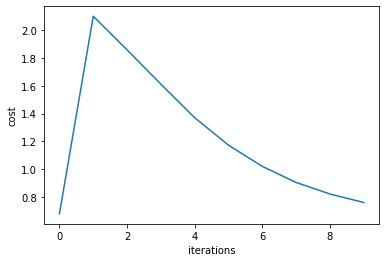

In [25]:
plt.plot(costs)
plt.xlabel('iterations')
plt.ylabel('cost')
plt.show()